In [111]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [118]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row
from pyspark.ml.linalg import Vectors

import random
spark = SparkSession.builder.appName("LSHS").getOrCreate()
# create a SparkSession object
it = iter(range(1, 60000))
data = spark.read.csv("/content/patches.csv")

# convert the data to a format compatible with LSH
data = data.rdd.map(lambda row: (next(it), Vectors.dense(row))).toDF(["id", "features"])

In [119]:
data.show()

+---+--------------------+
| id|            features|
+---+--------------------+
|  1|[52.0,65.0,81.0,6...|
|  2|[255.0,255.0,255....|
|  3|[20.0,5.0,3.0,10....|
|  4|[5.0,82.0,153.0,2...|
|  5|[105.0,108.0,108....|
|  6|[84.0,100.0,118.0...|
|  7|[254.0,255.0,255....|
|  8|[89.0,105.0,85.0,...|
|  9|[254.0,253.0,250....|
| 10|[116.0,119.0,96.0...|
| 11|[87.0,79.0,60.0,6...|
| 12|[4.0,3.0,8.0,1.0,...|
| 13|[248.0,251.0,254....|
| 14|[81.0,69.0,32.0,2...|
| 15|[255.0,255.0,255....|
| 16|[49.0,73.0,89.0,8...|
| 17|[21.0,30.0,26.0,4...|
| 18|[253.0,255.0,255....|
| 19|[4.0,0.0,15.0,0.0...|
| 20|[197.0,177.0,121....|
+---+--------------------+
only showing top 20 rows



In [120]:
data.count()

4824

In [151]:
num_hash_tables = 50
bucket_length = 100

In [152]:

m = [Vectors.dense([float(random.uniform(-1, 1)) for _ in range(len(data.first().features))]) for _ in range(num_hash_tables)]

In [153]:
def hash_vector(v, m, w):
    """Hash a vector using random projections."""
    return tuple(int((v.dot(m[i]) ) // w) for i in range(len(m)))

In [143]:
def manhattan_distance(x, y):
    """Calculate Manhattan distance between two vectors."""
    return sum(abs(x[i] - y[i]) for i in range(len(x)))

In [144]:
final_df = data.collect()

In [154]:
w = bucket_length

w= bucket_length
def find_nearest(n,k):
  global final_df
  query = final_df[n]['features']
  hashed_query = hash_vector(query, m, w)

  bucketed_data = data.rdd.map(lambda row:(row.id ,hash_vector(row.features, m, w)))
  candidate_buckets = bucketed_data.map(lambda x: (x[0],manhattan_distance(x[1],hashed_query))).collect()
  return sorted(candidate_buckets, key=lambda x: x[1])[:k]


In [155]:
def find_nearest_normal(n,k):
  global final_df
  query = final_df[n]['features']
  bucketed_data = data.rdd.map(lambda row:(row.id ,manhattan_distance(row.features, query))).collect()
  return sorted(bucketed_data, key=lambda x: x[1])[:k]

In [156]:
for i in range(100,1000,100):
 
  print(find_nearest(i,3))


[(101, 0), (2281, 109), (1399, 109)]
[(201, 0), (119, 168), (1889, 174)]
[(301, 0), (2210, 179), (1611, 184)]
[(401, 0), (1172, 165), (464, 175)]
[(501, 0), (1179, 63), (558, 88)]
[(601, 0), (473, 126), (374, 140)]
[(701, 0), (91, 142), (626, 153)]
[(801, 0), (144, 144), (1716, 153)]
[(901, 0), (1345, 189), (379, 193)]


In [157]:
for i in range(100,1000,100):

  print(find_nearest_normal(i,3))

[(101, 0.0), (2004, 8889.0), (2276, 9363.0)]
[(201, 0.0), (92, 9252.0), (605, 9252.0)]
[(301, 0.0), (1766, 10851.0), (2004, 10882.0)]
[(401, 0.0), (172, 9514.0), (1693, 9631.0)]
[(501, 0.0), (1179, 2483.0), (558, 3240.0)]
[(601, 0.0), (374, 3672.0), (796, 4281.0)]
[(701, 0.0), (91, 8895.0), (531, 9356.0)]
[(801, 0.0), (1716, 6643.0), (144, 6913.0)]
[(901, 0.0), (1839, 10411.0), (1377, 10558.0)]


In [162]:
ten_nearest_lsh = find_nearest(100,10)

In [161]:
ten_nearest_normal = find_nearest_normal(100,10)

In [167]:
import matplotlib.pyplot as plt


In [175]:
import numpy as np
def draw_picure(ten_nearest):
  for i in ten_nearest:
    id = i[0]
    u=final_df[id]['features']
    img_array = np.array(u).reshape(20, 20)

    # Plot the image using imshow
    plt.imshow(img_array, cmap='gray')
    

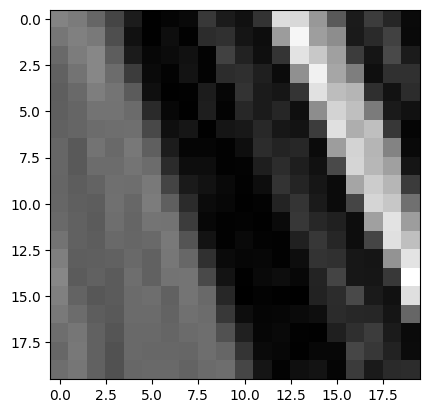

In [176]:
draw_picure(ten_nearest_lsh)
draw_picure(ten_nearest_normal)